# Notebook 02: Experimentos de Entrenamiento para Segmentación Dermatológica

**Objetivos del experimento:**
1. Entrenar y comparar seis arquitecturas: U-Net, Attention U-Net, Residual U-Net, U-Net++, DeepLabV3+ y TransUNet
2. Analizar el impacto de diferentes funciones de pérdida
3. Evaluar el rendimiento en el conjunto de validación
4. Documentar el proceso completo para el TFM

**Arquitecturas comparadas:**
- **U-Net Básica**: Arquitectura encoder-decoder original con skip connections
- **Attention U-Net**: U-Net con mecanismos de atención en skip connections
- **Residual U-Net**: U-Net con bloques residuales para mejor flujo de gradientes
- **U-Net++**: Nested U-Net con conexiones densas anidadas para mejor fusión multi-escala
- **DeepLabV3+**: Arquitectura con ASPP (Atrous Spatial Pyramid Pooling) y decoder ligero
- **TransUNet**: Híbrido CNN-Transformer que captura dependencias globales mediante self-attention

**Metodología:**
- Dataset: ISIC 2018 (2594 imágenes train, 100 val)
- Preprocesamiento: Redimensionado a 256x256, normalización ImageNet
- Entrenamiento: 5 épocas por modelo (para comparación rápida)
- Evaluación: Dice Score, IoU, Precisión, Recall

## 1. Configuración inicial

In [1]:
# Importaciones básicas
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import warnings
import gc
import random
warnings.filterwarnings('ignore')

def set_seed(seed: int = 42):
    """Fija todas las seeds para reproducibilidad"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
seed_worker = set_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
print(f" Seed: {SEED}")


import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True' # Habilitar liberación de memoria más agresiva

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

# Añadir src al path
PROJECT_ROOT = Path.cwd().parent if "notebooks" in str(Path.cwd()) else Path.cwd()
sys.path.append(str(PROJECT_ROOT))

# Importaciones personalizadas
from src.data_preparation.data_loader import ISICDataLoader
from src.models import UNet, AttentionUNet, ResidualUNet, UNetPlusPlus, DeepLabV3Plus, TransUNet
from src.models.losses import DiceLoss, FocalLoss, CombinedLoss
from src.models.metrics import SegmentationMetrics

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    total_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"Memoria total: {total_mem:.2f} GB")
    
    # Limpiar memoria al inicio
    torch.cuda.empty_cache()
    gc.collect()
    
    torch.backends.cuda.matmul.allow_tf32 = True  # Permite TF32 para mejor rendimiento

 Seed: 42
Dispositivo: cuda
GPU: NVIDIA GeForce RTX 4080 SUPER
Memoria total: 17.17 GB


## 2. Configuración de experimentos

In [2]:
# Configuración experimental con hiperparámetros específicos por modelo
# Basado en literatura y mejores prácticas para cada arquitectura

EXPERIMENT_CONFIG = {
    'base_path': '../data',
    'target_size': (256, 256),
    'batch_size': 16,
    'num_workers': 4,
    'epochs': 100,
    'seed': SEED,
    'use_amp': True,  # Automatic Mixed Precision

    # ============================================
    # LR WARMUP CONFIGURATION
    # ============================================
    'warmup': {
        'enabled': True,
        'epochs': 5,  # Épocas de warmup (subida gradual del LR)
        'start_factor': 0.1,  # LR inicial = LR * start_factor
    },
    
    # ============================================
    # EARLY STOPPING CONFIGURATION
    # ============================================
    'early_stopping': {
        'enabled': True,
        'patience': 10,          # Épocas sin mejora antes de parar
        'min_delta': 0.001,      # Mejora mínima para considerar progreso
        'monitor': 'val_dice',   # Métrica a monitorear (val_dice o val_loss)
    },
    
    'experiments': [
        {
            'name': 'U-Net Básica',
            'model_class': 'UNet',
            'model_kwargs': {'features': [64, 128, 256, 512]},
            'loss': 'combined',
            'loss_kwargs': {'losses': ['bce', 'dice'], 'weights': [0.5, 0.5]},
            # Hiperparámetros para CNNs entrenadas desde cero
            'learning_rate': 1e-4,
            'weight_decay': 1e-5,
            'scheduler': 'plateau',
            'scheduler_kwargs': {'factor': 0.5, 'patience': 5}
        },
        {
            'name': 'Attention U-Net',
            'model_class': 'AttentionUNet',
            'model_kwargs': {'features': [64, 128, 256, 512]},
            'loss': 'combined',
            'loss_kwargs': {'losses': ['bce', 'dice'], 'weights': [0.5, 0.5]},
            # Similar a U-Net, mecanismo de atención no requiere ajustes especiales
            'learning_rate': 1e-4,
            'weight_decay': 1e-5,
            'scheduler': 'plateau',
            'scheduler_kwargs': {'factor': 0.5, 'patience': 5}
        },
        {
            'name': 'Residual U-Net',
            'model_class': 'ResidualUNet',
            'model_kwargs': {'features': [64, 128, 256, 512]},
            'loss': 'combined',
            'loss_kwargs': {'losses': ['bce', 'dice'], 'weights': [0.5, 0.5]},
            # Conexiones residuales permiten LR ligeramente más alto
            'learning_rate': 1e-4,
            'weight_decay': 1e-5,
            'scheduler': 'plateau',
            'scheduler_kwargs': {'factor': 0.5, 'patience': 5}
        },
        {
            'name': 'U-Net++',
            'model_class': 'UNetPlusPlus',
            # Reducido para evitar saturar VRAM (consume mucha memoria por conexiones densas)
            'model_kwargs': {'features': [32, 64, 128, 256], 'deep_supervision': False},
            'loss': 'combined',
            'loss_kwargs': {'losses': ['bce', 'dice'], 'weights': [0.5, 0.5]},
            # Red más profunda, puede beneficiarse de más regularización
            'learning_rate': 1e-4,
            'weight_decay': 1e-4,
            'scheduler': 'plateau',
            'scheduler_kwargs': {'factor': 0.5, 'patience': 5}
        },
        {
            'name': 'DeepLabV3+',
            'model_class': 'DeepLabV3Plus',
            # ESCALADO: Mayor capacidad (eficiente en VRAM gracias a ASPP)
            'model_kwargs': {'features': [64, 128, 256, 512], 'aspp_channels': 512, 
                           'atrous_rates': [6, 12, 18]},
            'loss': 'combined',
            'loss_kwargs': {'losses': ['bce', 'dice'], 'weights': [0.5, 0.5]},
            # Sin backbone preentrenado, usamos LR estándar
            'learning_rate': 1e-4,
            'weight_decay': 1e-4,
            'scheduler': 'poly',  # Scheduler polynomial típico de DeepLab
            'scheduler_kwargs': {'power': 0.9}
        },
        {
            'name': 'TransUNet',
            'model_class': 'TransUNet',
            # ESCALADO: Mayor capacidad del Transformer (eficiente en VRAM)
            'model_kwargs': {'img_size': 256, 'base_features': 64, 'embed_dim': 512, 
                           'num_heads': 8, 'num_layers': 8},
            'loss': 'combined',
            'loss_kwargs': {'losses': ['bce', 'dice'], 'weights': [0.5, 0.5]},
            # Transformers requieren más regularización y warmup
            'learning_rate': 1e-4,
            'weight_decay': 0.01,  # Mayor weight decay para Transformers
            'scheduler': 'cosine',  # Cosine annealing típico para Transformers
            'scheduler_kwargs': {'T_max': 30, 'eta_min': 1e-6}
        }
    ]
}

print("CONFIGURACIÓN EXPERIMENTAL (Hiperparámetros Específicos por Modelo)")
print("="*70)
print(f"Base path: {EXPERIMENT_CONFIG['base_path']}")
print(f"Target size: {EXPERIMENT_CONFIG['target_size']}")
print(f"Batch size: {EXPERIMENT_CONFIG['batch_size']}")
print(f"Epochs: {EXPERIMENT_CONFIG['epochs']}")
print(f"Seed: {EXPERIMENT_CONFIG['seed']}")

# Warmup info
warmup_config = EXPERIMENT_CONFIG['warmup']
print(f"\nLR Warmup: {'Activado' if warmup_config['enabled'] else 'Desactivado'}")
if warmup_config['enabled']:
    print(f"   Épocas: {warmup_config['epochs']}, Start factor: {warmup_config['start_factor']}")

# Early stopping info
es_config = EXPERIMENT_CONFIG['early_stopping']
print(f"\nEarly Stopping: {'Activado' if es_config['enabled'] else 'Desactivado'}")
if es_config['enabled']:
    print(f"   Monitor: {es_config['monitor']}, Patience: {es_config['patience']}, Min delta: {es_config['min_delta']}")

print(f"\nModelos a entrenar: {len(EXPERIMENT_CONFIG['experiments'])}")
print("-"*70)
print(f"{'Modelo':<20} {'LR':<12} {'Weight Decay':<15} {'Scheduler':<12}")
print("-"*70)
for exp in EXPERIMENT_CONFIG['experiments']:
    print(f"{exp['name']:<20} {exp['learning_rate']:<12.0e} {exp['weight_decay']:<15.0e} {exp['scheduler']:<12}")

CONFIGURACIÓN EXPERIMENTAL (Hiperparámetros Específicos por Modelo)
Base path: ../data
Target size: (256, 256)
Batch size: 16
Epochs: 100
Seed: 42

LR Warmup: Activado
   Épocas: 5, Start factor: 0.1

Early Stopping: Activado
   Monitor: val_dice, Patience: 10, Min delta: 0.001

Modelos a entrenar: 6
----------------------------------------------------------------------
Modelo               LR           Weight Decay    Scheduler   
----------------------------------------------------------------------
U-Net Básica         1e-04        1e-05           plateau     
Attention U-Net      1e-04        1e-05           plateau     
Residual U-Net       1e-04        1e-05           plateau     
U-Net++              1e-04        1e-04           plateau     
DeepLabV3+           1e-04        1e-04           poly        
TransUNet            1e-04        1e-02           cosine      


## 3. Preparación de datos


PREPARANDO DATOS PARA ENTRENAMIENTO
Cargando datasets...
Creando datasets...
  Train: 2594 imágenes
  Val: 100 imágenes
  Test: 1000 imágenes
Creando DataLoaders...
Creando weighted sampler...
  Sampler creado con 2594 pesos
  Train Loader: 162 batches
  Val Loader: 7 batches
  Test Loader: 63 batches
Datasets creados (con seed=42 para reproducibilidad):
   - Train: 2594 imágenes
   - Val: 100 imágenes
   - Test: 1000 imágenes

Visualizando batch de entrenamiento de ejemplo...


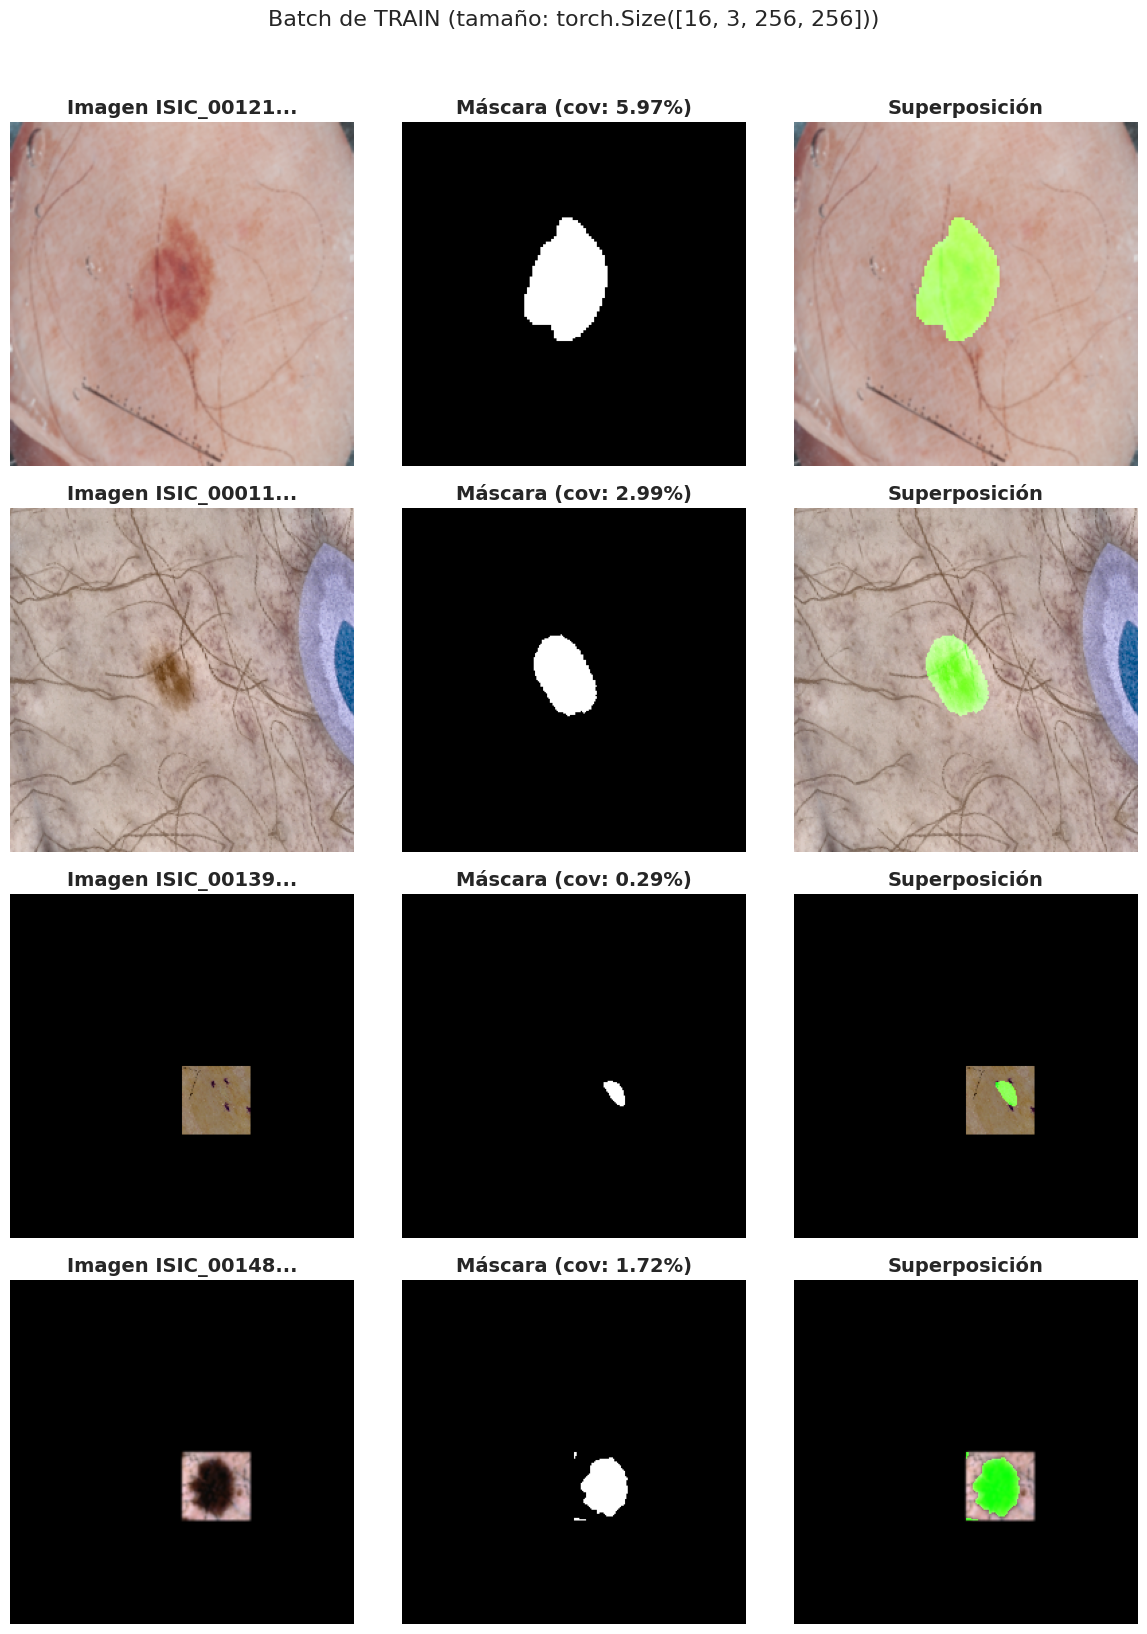


Estadísticas del batch (train):
  Batch shape: torch.Size([16, 3, 256, 256])
  Rango imagen: [-2.118, 2.640]
  Rango máscara: [0.000, 1.000]
  Cobertura media batch: 6.722%


In [3]:
print("\nPREPARANDO DATOS PARA ENTRENAMIENTO")
print("="*50)

# Crear DataLoader con reproducibilidad
data_loader = ISICDataLoader(
    base_path=EXPERIMENT_CONFIG['base_path'],
    batch_size=EXPERIMENT_CONFIG['batch_size'],
    target_size=EXPERIMENT_CONFIG['target_size'],
    num_workers=EXPERIMENT_CONFIG['num_workers'],
    use_class_balancing=True,
    debug=False
)

# Crear datasets y dataloaders
print("Cargando datasets...")
data_loader.create_datasets(use_processed=True, augment_train=True)

# Crear dataloaders con seeds para reproducibilidad
data_loader.create_dataloaders(
    shuffle_train=True,
    generator=g,  # Generator con seed fija
    worker_init_fn=seed_worker  # Inicialización reproducible de workers
)

print(f"Datasets creados (con seed={SEED} para reproducibilidad):")
print(f"   - Train: {len(data_loader.train_loader.dataset)} imágenes")
print(f"   - Val: {len(data_loader.val_loader.dataset)} imágenes")
print(f"   - Test: {len(data_loader.test_loader.dataset)} imágenes")

# Visualizar un batch de ejemplo
print("\nVisualizando batch de entrenamiento de ejemplo...")
data_loader.visualize_batch(num_samples=4, phase='train')

## 4. Función de entrenamiento por experimento

In [4]:
import time

def train_experiment(exp_config, train_loader, val_loader, device, epochs, save_dir=None, 
                     early_stopping_config=None, use_amp=False, warmup_config=None):
    """
    Entrena un modelo según la configuración experimental con hiperparámetros específicos
    
    Args:
        exp_config: Configuración del experimento (incluye hiperparámetros específicos)
        train_loader: DataLoader de entrenamiento
        val_loader: DataLoader de validación
        device: Dispositivo (cuda/cpu)
        epochs: Número de épocas de entrenamiento
        save_dir: Directorio para guardar resultados
        early_stopping_config: Configuración de early stopping (opcional)
        use_amp: Usar Mixed Precision Training (AMP)
        warmup_config: Configuración de LR warmup (opcional)
        
    Returns:
        Diccionario con resultados del entrenamiento
    """
    
    print(f"\nINICIANDO EXPERIMENTO: {exp_config['name']}")
    print("-" * 60)
    
    # Extraer hiperparámetros específicos del modelo
    lr = exp_config.get('learning_rate', 1e-4)
    weight_decay = exp_config.get('weight_decay', 1e-5)
    scheduler_type = exp_config.get('scheduler', 'plateau')
    scheduler_kwargs = exp_config.get('scheduler_kwargs', {})
    
    print(f"Hiperparámetros: LR={lr:.0e}, WD={weight_decay:.0e}, Scheduler={scheduler_type}")
    
    # Configurar AMP
    use_amp = use_amp and device.type == 'cuda'  # Solo en GPU
    scaler = GradScaler() if use_amp else None
    if use_amp:
        print(f"Mixed Precision (AMP): Activado")
    
    # Configurar warmup
    use_warmup = False
    warmup_epochs = 0
    warmup_start_factor = 0.1
    if warmup_config and warmup_config.get('enabled', False):
        use_warmup = True
        warmup_epochs = warmup_config.get('epochs', 3)
        warmup_start_factor = warmup_config.get('start_factor', 0.1)
        print(f"LR Warmup: {warmup_epochs} épocas (start_factor={warmup_start_factor})")
    
    # Configurar early stopping
    use_early_stopping = False
    es_patience = 10
    es_min_delta = 0.001
    es_monitor = 'val_dice'
    
    if early_stopping_config and early_stopping_config.get('enabled', False):
        use_early_stopping = True
        es_patience = early_stopping_config.get('patience', 10)
        es_min_delta = early_stopping_config.get('min_delta', 0.001)
        es_monitor = early_stopping_config.get('monitor', 'val_dice')
        print(f"Early Stopping: patience={es_patience}, min_delta={es_min_delta}, monitor={es_monitor}")
    
    # Crear modelo
    if exp_config['model_class'] == 'UNet':
        model = UNet(**exp_config.get('model_kwargs', {}))
    elif exp_config['model_class'] == 'AttentionUNet':
        model = AttentionUNet(**exp_config.get('model_kwargs', {}))
    elif exp_config['model_class'] == 'ResidualUNet':
        model = ResidualUNet(**exp_config.get('model_kwargs', {}))
    elif exp_config['model_class'] == 'UNetPlusPlus':
        model = UNetPlusPlus(**exp_config.get('model_kwargs', {}))
    elif exp_config['model_class'] == 'DeepLabV3Plus':
        model = DeepLabV3Plus(**exp_config.get('model_kwargs', {}))
    elif exp_config['model_class'] == 'TransUNet':
        model = TransUNet(**exp_config.get('model_kwargs', {}))
    else:
        raise ValueError(f"Modelo no soportado: {exp_config['model_class']}")
    
    model.to(device)
    print(f"Modelo creado: {model.__class__.__name__}")
    print(f"Parámetros: {sum(p.numel() for p in model.parameters()):,}")
    
    # Crear función de pérdida
    loss_name = exp_config.get('loss', 'combined')
    loss_kwargs = exp_config.get('loss_kwargs', {})
    
    if loss_name == 'bce':
        criterion = nn.BCEWithLogitsLoss()
    elif loss_name == 'dice':
        criterion = DiceLoss()
    elif loss_name == 'combined':
        criterion = CombinedLoss(**loss_kwargs)
    else:
        raise ValueError(f"Pérdida no soportada: {loss_name}")
    
    print(f"Función de pérdida: {criterion.__class__.__name__}")
    
    # Optimizador con hiperparámetros específicos del modelo
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )
    
    # ============================================
    # SCHEDULERS CON WARMUP
    # ============================================
    schedulers = []
    
    # 1. Warmup scheduler (si está habilitado)
    if use_warmup:
        warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer,
            start_factor=warmup_start_factor,
            end_factor=1.0,
            total_iters=warmup_epochs
        )
        schedulers.append(('warmup', warmup_scheduler))
    
    # 2. Main scheduler según configuración
    if scheduler_type == 'plateau':
        main_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', 
            factor=scheduler_kwargs.get('factor', 0.5), 
            patience=scheduler_kwargs.get('patience', 5)
        )
    elif scheduler_type == 'cosine':
        # Ajustar T_max para considerar warmup
        effective_epochs = epochs - warmup_epochs if use_warmup else epochs
        main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=max(effective_epochs, 1),
            eta_min=scheduler_kwargs.get('eta_min', 1e-6)
        )
    elif scheduler_type == 'poly':
        # Polynomial decay scheduler (típico de DeepLab)
        power = scheduler_kwargs.get('power', 0.9)
        effective_epochs = epochs - warmup_epochs if use_warmup else epochs
        main_scheduler = torch.optim.lr_scheduler.LambdaLR(
            optimizer,
            lr_lambda=lambda epoch: max((1 - epoch / effective_epochs) ** power, 0)
        )
    else:
        main_scheduler = None
    
    print(f"Scheduler: {scheduler_type}" + (f" (con warmup de {warmup_epochs} épocas)" if use_warmup else ""))
    
    # Métricas
    train_metrics = SegmentationMetrics()
    val_metrics = SegmentationMetrics()
    
    # Historial
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_dice': [],
        'val_dice': [],
        'train_iou': [],
        'val_iou': [],
        'learning_rate': [],
        'epoch_time': []  # Tiempo por época en segundos
    }
    
    # Entrenamiento
    best_val_dice = 0.0
    best_model_state = None
    total_start_time = time.time()
    
    # Early stopping state
    epochs_without_improvement = 0
    best_monitored_value = float('-inf') if es_monitor == 'val_dice' else float('inf')
    stopped_early = False
    final_epoch = epochs
    
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        
        in_warmup = use_warmup and epoch <= warmup_epochs
        print(f"\nÉpoca {epoch}/{epochs}{' (warmup)' if in_warmup else ''}")
        
        # Fase de entrenamiento
        model.train()
        train_metrics.reset()
        epoch_train_loss = 0.0
        
        for batch in train_loader:
            images = batch['image'].to(device, non_blocking=True)
            masks = batch['mask'].to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            
            # Forward pass con AMP
            if use_amp:
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                
                # Backward pass con scaler
                scaler.scale(loss).backward()
                
                # Gradient clipping para TransUNet
                if exp_config['model_class'] == 'TransUNet':
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                scaler.step(optimizer)
                scaler.update()
            else:
                # Forward pass normal
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping para TransUNet
                if exp_config['model_class'] == 'TransUNet':
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
            
            # Actualizar métricas
            epoch_train_loss += loss.detach().item()
            
            with torch.no_grad():
                train_metrics.update(outputs.detach().float(), masks)
            
            del images, masks, outputs, loss
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_results = train_metrics.compute()
        
        # Fase de validación
        model.eval()
        val_metrics.reset()
        epoch_val_loss = 0.0
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device, non_blocking=True)
                masks = batch['mask'].to(device, non_blocking=True)
                
                # Validación también con AMP para consistencia
                if use_amp:
                    with autocast():
                        outputs = model(images)
                        loss = criterion(outputs, masks)
                else:
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                
                epoch_val_loss += loss.item()
                val_metrics.update(outputs.float(), masks)
                
                del images, masks, outputs, loss
        
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_results = val_metrics.compute()
        
        # ============================================
        # ACTUALIZAR SCHEDULERS
        # ============================================
        current_lr = optimizer.param_groups[0]['lr']
        
        if use_warmup and epoch <= warmup_epochs:
            # Durante warmup, usar warmup scheduler
            warmup_scheduler.step()
        elif main_scheduler is not None:
            # Después de warmup, usar main scheduler
            if scheduler_type == 'plateau':
                main_scheduler.step(avg_val_loss)
            else:
                main_scheduler.step()
        
        # Calcular tiempo de época
        epoch_time = time.time() - epoch_start_time
        
        # Guardar historial
        history['train_loss'].append(float(avg_train_loss))
        history['val_loss'].append(float(avg_val_loss))
        history['train_dice'].append(float(train_results['dice']))
        history['val_dice'].append(float(val_results['dice']))
        history['train_iou'].append(float(train_results['iou']))
        history['val_iou'].append(float(val_results['iou']))
        history['learning_rate'].append(float(optimizer.param_groups[0]['lr']))
        history['epoch_time'].append(float(epoch_time))
        
        # Mostrar resultados
        print(f"   Train - Loss: {avg_train_loss:.4f}, Dice: {train_results['dice']:.4f}, IoU: {train_results['iou']:.4f}")
        print(f"   Val   - Loss: {avg_val_loss:.4f}, Dice: {val_results['dice']:.4f}, IoU: {val_results['iou']:.4f}")
        print(f"   LR: {optimizer.param_groups[0]['lr']:.2e} | Tiempo: {epoch_time:.1f}s")
        
        # Guardar mejor modelo
        if val_results['dice'] > best_val_dice:
            best_val_dice = float(val_results['dice'])
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            print(f"   Nuevo mejor modelo (Dice: {best_val_dice:.4f})")
        
        # ============================================
        # EARLY STOPPING CHECK (solo después de warmup)
        # ============================================
        if use_early_stopping and (not use_warmup or epoch > warmup_epochs):
            if es_monitor == 'val_dice':
                current_value = float(val_results['dice'])
                improved = current_value > best_monitored_value + es_min_delta
            else:
                current_value = float(avg_val_loss)
                improved = current_value < best_monitored_value - es_min_delta
            
            if improved:
                best_monitored_value = current_value
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                print(f"   Sin mejora en {es_monitor}: {epochs_without_improvement}/{es_patience}")
            
            if epochs_without_improvement >= es_patience:
                print(f"\nEARLY STOPPING activado en época {epoch}")
                print(f"   No hubo mejora en {es_monitor} durante {es_patience} épocas")
                stopped_early = True
                final_epoch = epoch
                break
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Tiempo total de entrenamiento
    total_time = time.time() - total_start_time
    avg_epoch_time = total_time / final_epoch
    
    # Limpiar modelo de GPU
    model.cpu()
    del optimizer, main_scheduler, scaler
    if use_warmup:
        del warmup_scheduler
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Resultados finales
    results = {
        'history': history,
        'best_val_dice': best_val_dice,
        'best_model_state': best_model_state,
        'config': exp_config,
        'total_time': total_time,
        'avg_epoch_time': avg_epoch_time,
        'stopped_early': stopped_early,
        'final_epoch': final_epoch,
        'used_amp': use_amp,
        'warmup_epochs': warmup_epochs if use_warmup else 0
    }
    
    print(f"\nExperimento completado: {exp_config['name']}")
    print(f"   Mejor Val Dice: {best_val_dice:.4f}")
    print(f"   Épocas entrenadas: {final_epoch}/{epochs}" + (" (early stop)" if stopped_early else ""))
    print(f"   Tiempo total: {total_time/60:.1f} min ({avg_epoch_time:.1f}s/época)")
    
    return results

## 5. Ejecución de todos los experimentos

In [5]:
import gc  # Para garbage collection

def cleanup_gpu_memory():
    """Limpieza agresiva de memoria GPU"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        torch.cuda.synchronize()

print("\n" + "="*70)
print("EJECUTANDO TODOS LOS EXPERIMENTOS")
print("="*70)
print(f"   Seed: {EXPERIMENT_CONFIG['seed']} (reproducible)")
print(f"   LR Warmup: {EXPERIMENT_CONFIG['warmup']['epochs']} épocas" if EXPERIMENT_CONFIG['warmup']['enabled'] else "   LR Warmup: Desactivado")
print(f"   Early Stopping: patience={EXPERIMENT_CONFIG['early_stopping']['patience']}" if EXPERIMENT_CONFIG['early_stopping']['enabled'] else "   Early Stopping: Desactivado")

# Directorio para guardar resultados
results_dir = Path('experiments/notebook_experiments')
results_dir.mkdir(parents=True, exist_ok=True)

# Ejecutar cada experimento
all_results = {}
total_experiments_start = time.time()

for exp_idx, exp_config in enumerate(EXPERIMENT_CONFIG['experiments']):
    exp_name = exp_config['name'].replace(' ', '_').lower()
    exp_save_dir = results_dir / exp_name
    exp_save_dir.mkdir(exist_ok=True)
    
    # Limpieza preventiva antes de cada experimentoP
    cleanup_gpu_memory()
    
    # Re-fijar seed antes de cada experimento para reproducibilidad exacta
    set_seed(EXPERIMENT_CONFIG['seed'])
    
    # Entrenar con todas las mejoras
    results = train_experiment(
        exp_config=exp_config,
        train_loader=data_loader.train_loader,
        val_loader=data_loader.val_loader,
        device=device,
        epochs=EXPERIMENT_CONFIG['epochs'],
        save_dir=exp_save_dir,
        early_stopping_config=EXPERIMENT_CONFIG.get('early_stopping'),
        use_amp=EXPERIMENT_CONFIG.get('use_amp', False),
        warmup_config=EXPERIMENT_CONFIG.get('warmup')
    )
    
    # Guardar modelo a disco ANTES de limpiar
    if results['best_model_state'] is not None:
        model_path = exp_save_dir / 'best_model.pth'
        torch.save({
            'model_state_dict': results['best_model_state'],
            'config': exp_config,
            'history': results['history'],
            'best_val_dice': results['best_val_dice'],
            'hyperparameters': {
                'learning_rate': exp_config.get('learning_rate'),
                'weight_decay': exp_config.get('weight_decay'),
                'scheduler': exp_config.get('scheduler')
            },
            'timing': {
                'total_time': results['total_time'],
                'avg_epoch_time': results['avg_epoch_time'],
                'epoch_times': results['history']['epoch_time']
            },
            'early_stopping': {
                'stopped_early': results['stopped_early'],
                'final_epoch': results['final_epoch'],
                'max_epochs': EXPERIMENT_CONFIG['epochs']
            },
            'training_config': {
                'seed': EXPERIMENT_CONFIG['seed'],
                'use_amp': results['used_amp'],
                'warmup_epochs': results['warmup_epochs']
            }
        }, model_path)
        print(f"Modelo guardado en: {model_path}")
    
    # Guardar historial como CSV
    history_df = pd.DataFrame(results['history'])
    history_path = exp_save_dir / 'training_history.csv'
    history_df.to_csv(history_path, index=False)
    print(f"Historial guardado en: {history_path}")
    
    # ============================================
    # LIMPIEZA AGRESIVA DE MEMORIA GPU
    # ============================================
    all_results[exp_config['name']] = {
        'history': results['history'].copy(),
        'best_val_dice': results['best_val_dice'],
        'config': exp_config,
        'model_path': str(exp_save_dir / 'best_model.pth'),
        'total_time': results['total_time'],
        'avg_epoch_time': results['avg_epoch_time'],
        'stopped_early': results['stopped_early'],
        'final_epoch': results['final_epoch'],
        'used_amp': results['used_amp'],
        'warmup_epochs': results['warmup_epochs']
    }
    
    if 'best_model_state' in results and results['best_model_state'] is not None:
        del results['best_model_state']
    
    del results
    del history_df
    
    cleanup_gpu_memory()
    
    print("-" * 60)
    
    time.sleep(2)

total_experiments_time = time.time() - total_experiments_start

print("\nTODOS LOS EXPERIMENTOS COMPLETADOS!")
print(f"   Modelos entrenados: {len(all_results)}")
print(f"   Tiempo total: {total_experiments_time/60:.1f} minutos")
print(f"   Resultados guardados en: {results_dir}")

# Resumen de tiempos y early stopping
print("\nRESUMEN DE TIEMPOS POR MODELO:")
print("-" * 70)
for name, res in all_results.items():
    es_info = " (early stop)" if res['stopped_early'] else ""
    epochs_info = f"{res['final_epoch']}/{EXPERIMENT_CONFIG['epochs']} épocas"
    print(f"   {name}: {res['total_time']/60:.1f} min ({res['avg_epoch_time']:.1f}s/época) - {epochs_info}{es_info}")


EJECUTANDO TODOS LOS EXPERIMENTOS
   Seed: 42 (reproducible)
   LR Warmup: 5 épocas
   Early Stopping: patience=10

INICIANDO EXPERIMENTO: U-Net Básica
------------------------------------------------------------
Hiperparámetros: LR=1e-04, WD=1e-05, Scheduler=plateau
Mixed Precision (AMP): Activado
LR Warmup: 5 épocas (start_factor=0.1)
Early Stopping: patience=10, min_delta=0.001, monitor=val_dice
Modelo creado: UNet
Parámetros: 31,043,521
Función de pérdida: CombinedLoss
Scheduler: plateau (con warmup de 5 épocas)

Época 1/100 (warmup)
   Train - Loss: 0.6104, Dice: 0.5097, IoU: 0.3601
   Val   - Loss: 0.4411, Dice: 0.7184, IoU: 0.5619
   LR: 2.80e-05 | Tiempo: 20.0s
   Nuevo mejor modelo (Dice: 0.7184)

Época 2/100 (warmup)
   Train - Loss: 0.4978, Dice: 0.6966, IoU: 0.5468
   Val   - Loss: 0.3900, Dice: 0.7850, IoU: 0.6467
   LR: 4.60e-05 | Tiempo: 18.9s
   Nuevo mejor modelo (Dice: 0.7850)

Época 3/100 (warmup)
   Train - Loss: 0.4467, Dice: 0.7247, IoU: 0.5804
   Val   - Loss: 0

## 6. Visualización comparativa de resultados


VISUALIZANDO RESULTADOS COMPARATIVOS


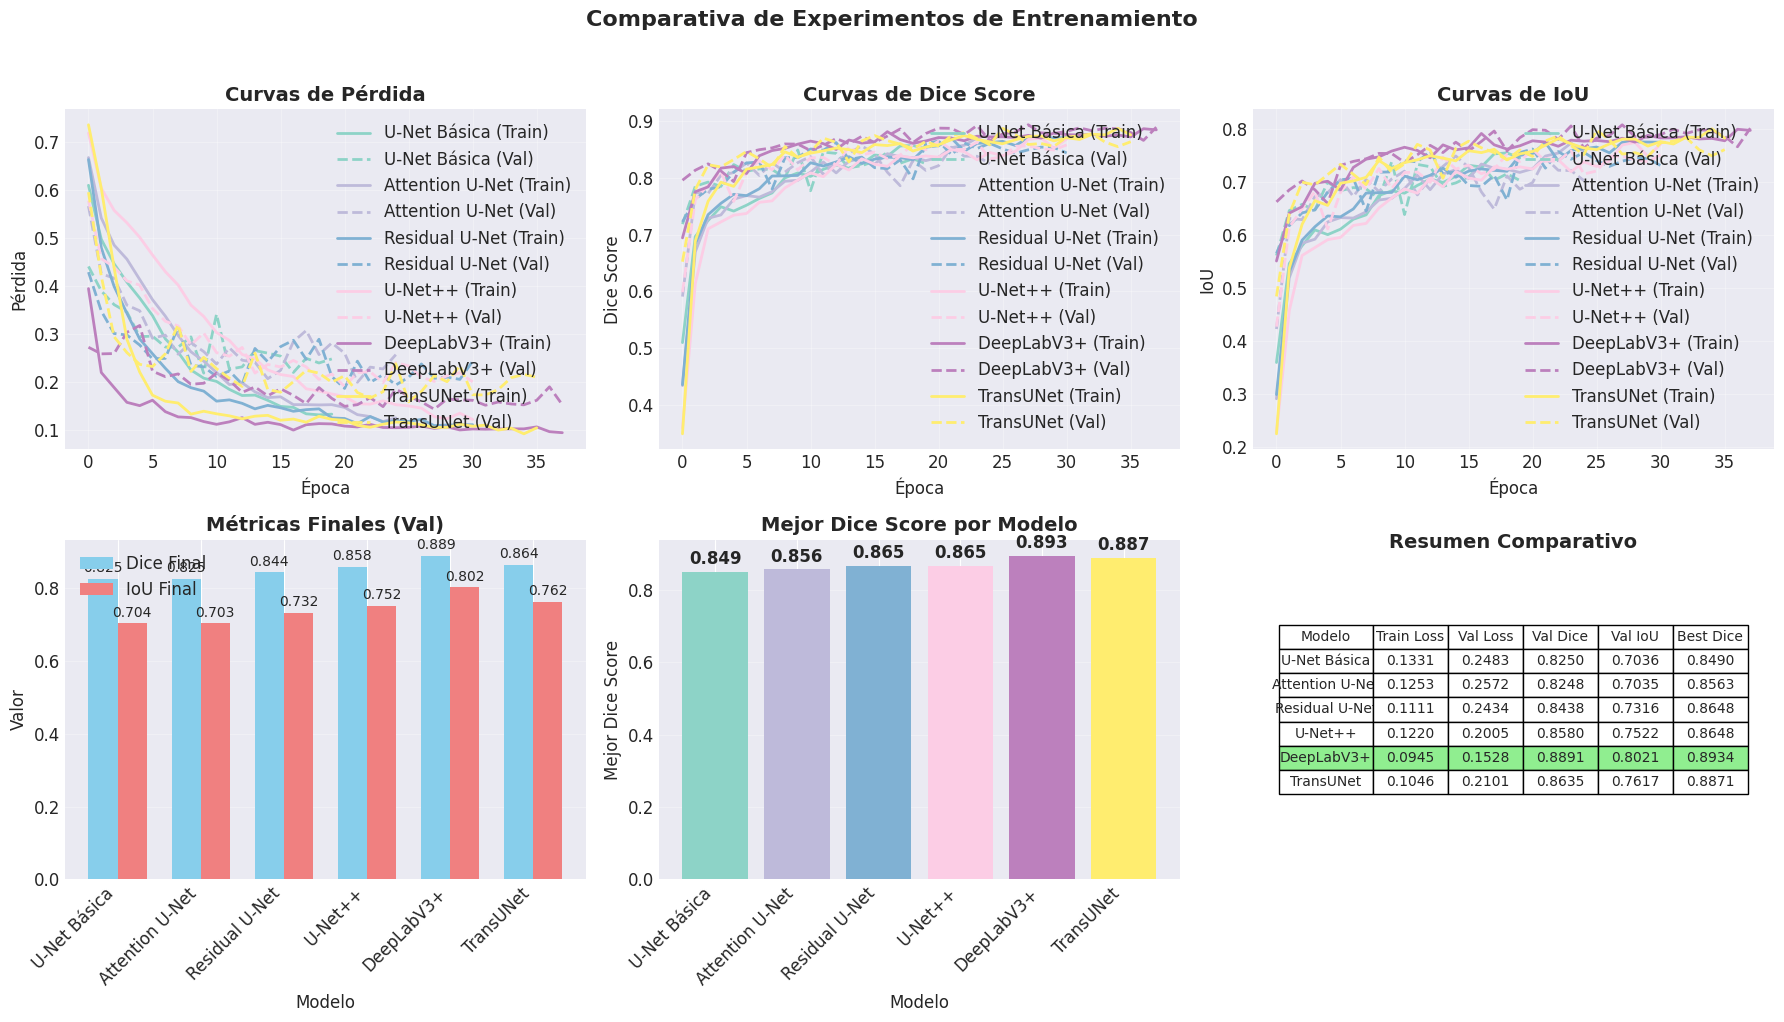

Gráfico comparativo guardado en: experiments/notebook_experiments/experiments_comparison.png


In [6]:
print("\nVISUALIZANDO RESULTADOS COMPARATIVOS")
print("="*50)

# Crear figura para comparación
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
colors = plt.cm.Set3(np.linspace(0, 1, len(all_results)))

# Gráfico 1: Curvas de pérdida
ax = axes[0, 0]
for (name, results), color in zip(all_results.items(), colors):
    ax.plot(results['history']['train_loss'], label=f'{name} (Train)', color=color, linewidth=2)
    ax.plot(results['history']['val_loss'], label=f'{name} (Val)', color=color, linewidth=2, linestyle='--')
ax.set_title('Curvas de Pérdida', fontsize=14, fontweight='bold')
ax.set_xlabel('Época')
ax.set_ylabel('Pérdida')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfico 2: Curvas de Dice Score
ax = axes[0, 1]
for (name, results), color in zip(all_results.items(), colors):
    ax.plot(results['history']['train_dice'], label=f'{name} (Train)', color=color, linewidth=2)
    ax.plot(results['history']['val_dice'], label=f'{name} (Val)', color=color, linewidth=2, linestyle='--')
ax.set_title('Curvas de Dice Score', fontsize=14, fontweight='bold')
ax.set_xlabel('Época')
ax.set_ylabel('Dice Score')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfico 3: Curvas de IoU
ax = axes[0, 2]
for (name, results), color in zip(all_results.items(), colors):
    ax.plot(results['history']['train_iou'], label=f'{name} (Train)', color=color, linewidth=2)
    ax.plot(results['history']['val_iou'], label=f'{name} (Val)', color=color, linewidth=2, linestyle='--')
ax.set_title('Curvas de IoU', fontsize=14, fontweight='bold')
ax.set_xlabel('Época')
ax.set_ylabel('IoU')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfico 4: Comparación final de métricas
ax = axes[1, 0]
model_names = list(all_results.keys())
final_val_dice = [results['history']['val_dice'][-1] for results in all_results.values()]
final_val_iou = [results['history']['val_iou'][-1] for results in all_results.values()]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax.bar(x - width/2, final_val_dice, width, label='Dice Final', color='skyblue')
bars2 = ax.bar(x + width/2, final_val_iou, width, label='IoU Final', color='lightcoral')

ax.set_title('Métricas Finales (Val)', fontsize=14, fontweight='bold')
ax.set_xlabel('Modelo')
ax.set_ylabel('Valor')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Añadir valores en barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Gráfico 5: Mejor Dice Score por modelo
ax = axes[1, 1]
best_dice = [results['best_val_dice'] for results in all_results.values()]
bars = ax.bar(model_names, best_dice, color=colors)
ax.set_title('Mejor Dice Score por Modelo', fontsize=14, fontweight='bold')
ax.set_xlabel('Modelo')
ax.set_ylabel('Mejor Dice Score')
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

for bar, dice in zip(bars, best_dice):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
           f'{dice:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 6: Resumen estadístico
ax = axes[1, 2]
ax.axis('off')

# Crear tabla de resumen
summary_data = []
for name, results in all_results.items():
    summary_data.append([
        name,
        f"{results['history']['train_loss'][-1]:.4f}",
        f"{results['history']['val_loss'][-1]:.4f}",
        f"{results['history']['val_dice'][-1]:.4f}",
        f"{results['history']['val_iou'][-1]:.4f}",
        f"{results['best_val_dice']:.4f}"
    ])

table = ax.table(cellText=summary_data,
                 colLabels=['Modelo', 'Train Loss', 'Val Loss', 'Val Dice', 'Val IoU', 'Best Dice'],
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.15, 0.12, 0.12, 0.12, 0.12, 0.12])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Resaltar mejor modelo
best_dice_idx = np.argmax(best_dice)
for i in range(len(summary_data[0])):
    table[(best_dice_idx + 1, i)].set_facecolor('#90EE90')  # Verde claro

ax.set_title('Resumen Comparativo', fontsize=14, fontweight='bold', y=0.95)

plt.suptitle('Comparativa de Experimentos de Entrenamiento', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Guardar figura
fig_path = results_dir / 'experiments_comparison.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Gráfico comparativo guardado en: {fig_path}")

## 7. Análisis de resultados

In [7]:
print("\n🔍 ANÁLISIS DE RESULTADOS")
print("="*50)

# Calcular estadísticas
analysis_results = []

for name, results in all_results.items():
    history = results['history']
    
    # Calcular mejoras
    dice_improvement = history['val_dice'][-1] - history['val_dice'][0]
    loss_improvement = history['val_loss'][0] - history['val_loss'][-1]
    
    # Calcular overfitting (diferencia train-val)
    overfitting_dice = history['train_dice'][-1] - history['val_dice'][-1]
    overfitting_loss = history['val_loss'][-1] - history['train_loss'][-1]
    
    # Tiempos
    total_time = results.get('total_time', sum(history.get('epoch_time', [0])))
    avg_epoch_time = results.get('avg_epoch_time', total_time / len(history['val_dice']))
    
    analysis_results.append({
        'Modelo': name,
        'Dice Inicial': history['val_dice'][0],
        'Dice Final': history['val_dice'][-1],
        'Mejora Dice': dice_improvement,
        'Mejor Dice': results['best_val_dice'],
        'Overfitting Dice': overfitting_dice,
        'Loss Inicial': history['val_loss'][0],
        'Loss Final': history['val_loss'][-1],
        'Mejora Loss': loss_improvement,
        'Overfitting Loss': overfitting_loss,
        'Épocas para converger': np.argmax(history['val_dice']) + 1,
        'Tiempo Total (min)': total_time / 60,
        'Tiempo/Época (s)': avg_epoch_time
    })

# Crear DataFrame
analysis_df = pd.DataFrame(analysis_results)
analysis_df = analysis_df.sort_values('Mejor Dice', ascending=False)

print("\nANÁLISIS COMPARATIVO")
print(analysis_df.to_string(index=False))

# Guardar análisis
analysis_path = results_dir / 'analysis_results.csv'
analysis_df.to_csv(analysis_path, index=False)
print(f"\nAnálisis guardado en: {analysis_path}")

# Análisis de eficiencia (Dice por minuto de entrenamiento)
print("\nANÁLISIS DE EFICIENCIA (Rendimiento vs Tiempo):")
print("-" * 60)
for _, row in analysis_df.iterrows():
    dice_per_min = row['Mejor Dice'] / row['Tiempo Total (min)'] if row['Tiempo Total (min)'] > 0 else 0
    print(f"   {row['Modelo']}: {row['Mejor Dice']:.4f} Dice en {row['Tiempo Total (min)']:.1f} min "
          f"({row['Tiempo/Época (s)']:.1f}s/época)")


🔍 ANÁLISIS DE RESULTADOS

ANÁLISIS COMPARATIVO
         Modelo  Dice Inicial  Dice Final  Mejora Dice  Mejor Dice  Overfitting Dice  Loss Inicial  Loss Final  Mejora Loss  Overfitting Loss  Épocas para converger  Tiempo Total (min)  Tiempo/Época (s)
     DeepLabV3+      0.795729    0.889118     0.093390    0.893364         -0.004690      0.272641    0.152764     0.119877          0.058282                     28            4.285995          6.767361
      TransUNet      0.652204    0.863513     0.211309    0.887055          0.012017      0.595868    0.210093     0.385775          0.105479                     26            4.760150          7.933583
 Residual U-Net      0.722165    0.843755     0.121590    0.864849          0.026998      0.429262    0.243445     0.185817          0.132305                     21           11.124005         21.530332
        U-Net++      0.598491    0.857983     0.259492    0.864771          0.010237      0.578241    0.200475     0.377766          0.07845

## 8. Conclusiones preliminares

In [8]:
print("\n" + "="*60)
print("CONCLUSIONES PRELIMINARES DE LOS EXPERIMENTOS")
print("="*60)

# Mejor modelo
best_model_row = analysis_df.iloc[0]
print(f"\nMEJOR MODELO: {best_model_row['Modelo']}")
print(f"   • Dice Score final: {best_model_row['Dice Final']:.4f}")
print(f"   • Mejor Dice Score: {best_model_row['Mejor Dice']:.4f}")
print(f"   • Mejora durante entrenamiento: {best_model_row['Mejora Dice']:.4f}")
print(f"   • Overfitting (Dice): {best_model_row['Overfitting Dice']:.4f}")

# Hallazgos generales
print("\nHALLAZGOS GENERALES:")
for idx, row in analysis_df.iterrows():
    print(f"   • {row['Modelo']}: Mejoró {row['Mejora Dice']:.4f} en Dice, "
          f"convergió en {row['Épocas para converger']} épocas")


CONCLUSIONES PRELIMINARES DE LOS EXPERIMENTOS

MEJOR MODELO: DeepLabV3+
   • Dice Score final: 0.8891
   • Mejor Dice Score: 0.8934
   • Mejora durante entrenamiento: 0.0934
   • Overfitting (Dice): -0.0047

HALLAZGOS GENERALES:
   • DeepLabV3+: Mejoró 0.0934 en Dice, convergió en 28 épocas
   • TransUNet: Mejoró 0.2113 en Dice, convergió en 26 épocas
   • Residual U-Net: Mejoró 0.1216 en Dice, convergió en 21 épocas
   • U-Net++: Mejoró 0.2595 en Dice, convergió en 21 épocas
   • Attention U-Net: Mejoró 0.2341 en Dice, convergió en 15 épocas
   • U-Net Básica: Mejoró 0.1066 en Dice, convergió en 10 épocas


## 9. Guardar resultados completos

In [9]:
print("\nGUARDANDO RESULTADOS COMPLETOS")
print("="*50)

# Crear archivo de resumen del experimento
experiment_summary = {
    'configuracion': EXPERIMENT_CONFIG,
    'resultados': {name: {
        'best_val_dice': results['best_val_dice'],
        'final_val_dice': results['history']['val_dice'][-1],
        'final_val_iou': results['history']['val_iou'][-1],
        'model_class': results['config']['model_class'],
        'loss_function': results['config']['loss']
    } for name, results in all_results.items()},
    'analisis': analysis_results,
    'timestamp': pd.Timestamp.now().isoformat()
}

# Guardar como JSON
import json
summary_path = results_dir / 'experiment_summary.json'
with open(summary_path, 'w') as f:
    json.dump(experiment_summary, f, indent=2, default=str)

print(f"Resumen del experimento guardado en: {summary_path}")

# Mostrar rutas de todos los archivos generados
print("\nARCHIVOS GENERADOS:")
for file_path in results_dir.rglob('*'):
    if file_path.is_file():
        print(f"   • {file_path.relative_to(results_dir)}")

print("\n" + "="*60)
print("NOTEBOOK DE EXPERIMENTOS COMPLETADO EXITOSAMENTE")
print("="*60)


GUARDANDO RESULTADOS COMPLETOS
Resumen del experimento guardado en: experiments/notebook_experiments/experiment_summary.json

ARCHIVOS GENERADOS:
   • experiments_comparison.png
   • analysis_results.csv
   • experiment_summary.json
   • transunet/best_model.pth
   • transunet/training_history.csv
   • u-net_básica/best_model.pth
   • u-net_básica/training_history.csv
   • u-net++/best_model.pth
   • u-net++/training_history.csv
   • attention_u-net/best_model.pth
   • attention_u-net/training_history.csv
   • deeplabv3+/best_model.pth
   • deeplabv3+/training_history.csv
   • residual_u-net/best_model.pth
   • residual_u-net/training_history.csv

NOTEBOOK DE EXPERIMENTOS COMPLETADO EXITOSAMENTE
